In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import FitFailedWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Preprocessing

In [93]:
df = pd.read_csv('occupancy_estimation.csv')

average_light = [(s1 + s2 + s3 + s4) / 4 for s1, s2, s3, s4 in zip(
    df["S1_Light"], df["S2_Light"], df["S3_Light"], df["S4_Light"])]

average_sound = [(s1 + s2 + s3 + s4) / 4 for s1, s2, s3, s4 in zip(
    df["S1_Sound"], df["S2_Sound"], df["S3_Sound"], df["S4_Sound"])]

average_temp = [(s1 + s2 + s3 + s4) / 4 for s1, s2, s3, s4 in zip(
    df["S1_Temp"], df["S2_Temp"], df["S3_Temp"], df["S4_Temp"])]

pir = [max(s6, s7) for s6, s7 in zip(df["S6_PIR"], df["S7_PIR"])]

features = pd.DataFrame({
    "Light (Lux)": average_light,
    "Sound (Volts)": average_sound,
    "Temp (C)": average_temp,
    "PIR": pir,
    "CO2 (PPM)": df["S5_CO2"],
    "CO2 Slope": df["S5_CO2_Slope"]
})

X = features.to_numpy()
y = df['Room_Occupancy_Count'].to_numpy()

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=77)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=77)

## Plots

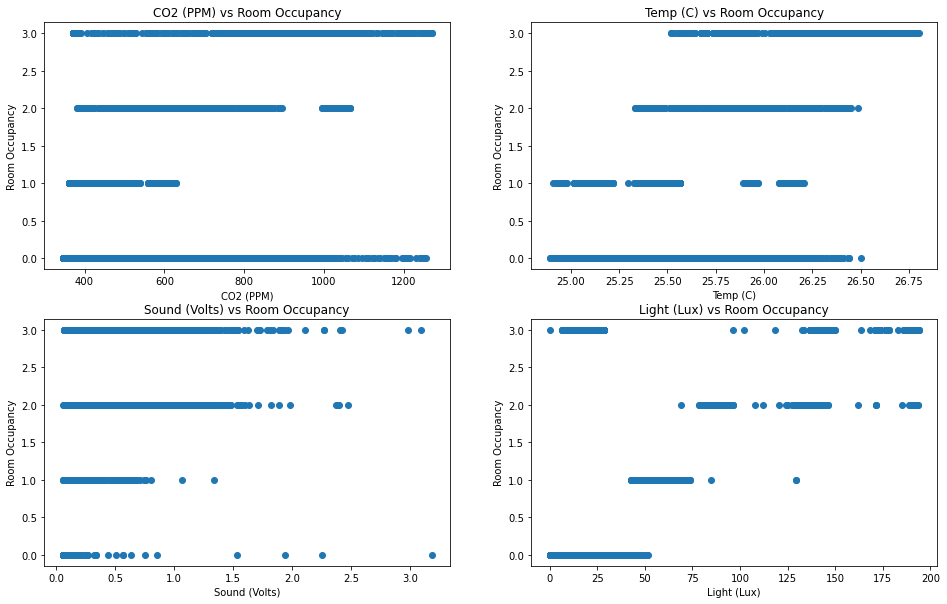

In [94]:
columns = ['CO2 (PPM)', 'Temp (C)', 'Sound (Volts)', 'Light (Lux)']

plt.figure(figsize=(16, 10))
for index, column in enumerate(columns):
    data = features[column].to_numpy().reshape(-1, 1)
    plt.subplot(len(columns) // 2, 2, index + 1)
    plt.scatter(data, y)
    plt.xlabel(column)
    plt.ylabel('Room Occupancy')
    plt.title(f'{column} vs Room Occupancy')

plt.show()


[Text(0, 0.5, 'Occupied'), Text(0, 1.5, 'Unoccupied')]

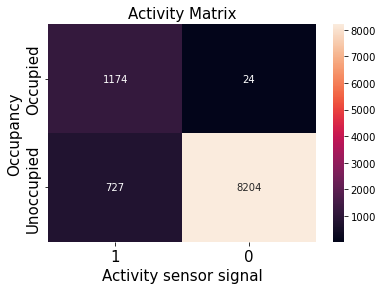

In [95]:
occupied_active, unoccupied_active, occupied_inactive, unoccupied_inactive = (0, 0, 0, 0)

for movement, occupancy in zip(pir, y):
    if movement == 1 and occupancy > 0:
        occupied_active += 1
    elif movement == 1 and occupancy == 0:
        unoccupied_active += 1
    elif movement == 0 and occupancy > 0:
        occupied_inactive += 1
    else:
        unoccupied_inactive += 1

matrix = [[occupied_active, unoccupied_active], [occupied_inactive, unoccupied_inactive]]

ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Activity sensor signal',fontsize=15)
ax.set_ylabel('Occupancy',fontsize=15)
ax.set_title('Activity Matrix',fontsize=15)
ax.xaxis.set_ticklabels(['1', '0'],fontsize=15)
ax.yaxis.set_ticklabels(['Occupied', 'Unoccupied'],fontsize=15)


## KMeans

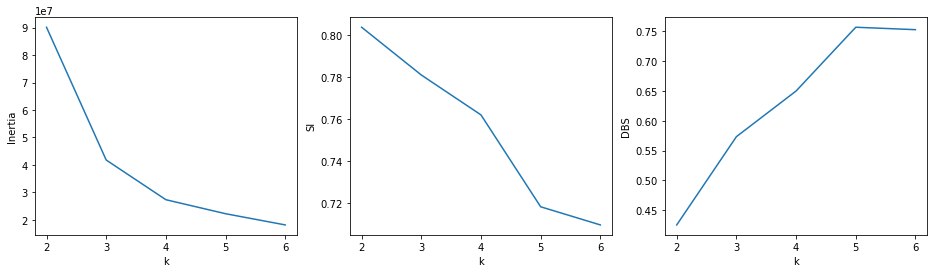

In [96]:
inertia = []
SI = []
DBS = []

X_cluster = features.drop(['PIR', 'CO2 Slope'], axis=1)

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k).fit(X_cluster)
    
    si = silhouette_score(X_cluster, kmeans.labels_)
    dbs = davies_bouldin_score(X_cluster, kmeans.labels_)
    
    inertia.append(kmeans.inertia_)
    SI.append(si)
    DBS.append(dbs)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.plot(np.arange(2,7),inertia)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xticks(np.arange(2,7))
plt.subplot(1,3,2)
plt.plot(np.arange(2,7),SI)
plt.xlabel('k')
plt.ylabel('SI')
plt.xticks(np.arange(2,7))
plt.subplot(1,3,3)
plt.plot(np.arange(2,7),DBS)
plt.xlabel('k')
plt.ylabel('DBS')
plt.xticks(np.arange(2,7))
plt.show()

In [97]:
kmeans = KMeans(n_clusters = 4)

kmeans.fit(X_cluster)
si = silhouette_score(X_cluster, kmeans.labels_)
dbs = davies_bouldin_score(X_cluster, kmeans.labels_)

print(f'inertia: {kmeans.inertia_}')
print(f'silhouette: {si}')
print(f'davies_bouldin_score: {dbs}')

inertia: 27318043.8502322
silhouette: 0.7621564198222979
davies_bouldin_score: 0.6499888563399825


## Logistic regression

In [98]:
# Standardization
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler = StandardScaler().fit(X_val)
X_val_scaled = scaler.transform(X_val)

In [99]:
# Find the best params for LogisticRegression with grid search
C_candidates = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty_candidates = ['l1', 'l2', 'elasticnet']
solver_candidates = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
grid = { "solver": solver_candidates, "penalty": penalty_candidates, "C": C_candidates, "max_iter": [10000] }
grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid=grid, n_jobs=-1, scoring='accuracy', error_score=0)
warnings.filterwarnings('ignore', category=FitFailedWarning) # Supress the fit failed warnings
grid_result = grid_search.fit(X_train_scaled, y_train)

    
print(f'{grid_result.best_params_} resulted in best score ({grid_result.best_score_})')

{'C': 100, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'} resulted in best score (0.9571483754667582)


Training accuracy: 0.9581358609794629
Validation accuracy: 0.9557836557441769


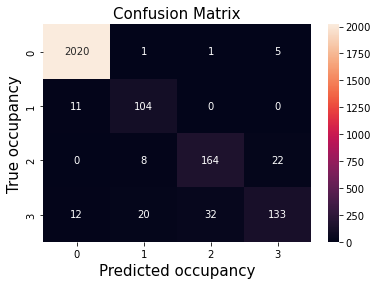

In [100]:
# Fit to logistic regression model
log_regr = LogisticRegression(C=100, max_iter=10000, solver="saga", penalty="l1")
log_regr.fit(X_train_scaled, y_train)

# Calculating training accuracy
y_train_pred = log_regr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculating testing accuracy
y_val_pred = log_regr.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Confusion matrix
conf_mat = confusion_matrix(y_val, y_val_pred)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted occupancy',fontsize=15)
ax.set_ylabel('True occupancy',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)

print(f'Training accuracy: {train_accuracy}')
print(f'Validation accuracy: {val_accuracy}')
plt.show()

## Random Forest

In [101]:
# Find the best params for RandomForest with grid search
estimator_candidates = [10, 100, 200]
max_features_candidates = ['sqrt', 'log2', None]
min_samples_leaf_candidates = list(range(10))
grid = { "n_estimators": estimator_candidates, "max_features": max_features_candidates, "min_samples_leaf": min_samples_leaf_candidates }
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid=grid, n_jobs=-1, scoring='accuracy', error_score=0)
warnings.filterwarnings('ignore', category=FitFailedWarning) # Supress the fit failed warnings
grid_result = grid_search.fit(X_train, y_train)

    
print(f'{grid_result.best_params_} resulted in best score ({grid_result.best_score_})')

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} resulted in best score (0.9968404808634002)


Training accuracy: 1.0
Validation accuracy: 0.9964469009080142


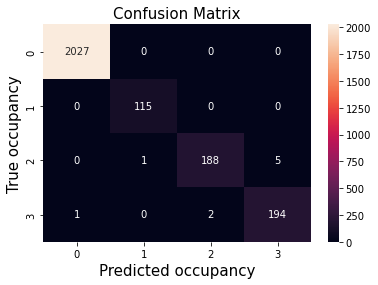

In [102]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

# Calculating training accuracy
y_train_pred = random_forest.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculating testing accuracy
y_val_pred = random_forest.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Confusion matrix
conf_mat = confusion_matrix(y_val, y_val_pred)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted occupancy',fontsize=15)
ax.set_ylabel('True occupancy',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)

print(f'Training accuracy: {train_accuracy}')
print(f'Validation accuracy: {val_accuracy}')
plt.show()

## Test with the chosen method with the test set

Test accuracy: 0.9940758293838863


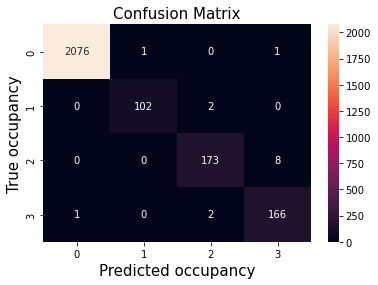

In [105]:
# Calculate test accuracy
y_test_pred = random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_mat = confusion_matrix(y_test, y_test_pred)
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted occupancy',fontsize=15)
ax.set_ylabel('True occupancy',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)

print(f'Test accuracy: {test_accuracy}')
plt.show()